In [1]:
import pandas as pd
import numpy as np

# Getting the Input and Preprocessing

In [3]:
pip install spacy

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.4
    Uninstalling colorama-0.4.4:
      Successfully uninstalled colorama-0.4.4
  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.1.0
Note: you may need to restart the kernel to use updated packages.    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-5.1.0



In [2]:
import spacy
import os

nlp = spacy.load('en_core_web_lg')


ModuleNotFoundError: No module named 'spacy'

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean(val):
    '''
    Clean the row description
    '''
    doc = nlp(val)
    text = ''
    for w in doc:
        if not w.is_stop and not w.is_punct and not w.like_num: 
            text += w.lemma_.lower() + ' '
    text = text.strip()
    return text

def clean_prompt(prompt):
    '''
    Clean the Prompt

    Change: Concatenated TfIdf
    - Cut into a threshold number
    - Less than 10 words etc.
    '''
    doc = nlp(prompt)
    txt = ''
    for w in doc:
        if not w.is_stop and not w.is_punct and not w.like_num:
            txt += w.lemma_.lower() + ' '
    txt = txt.strip()

    vect = TfidfVectorizer()
    X = vect.fit_transform([txt])
    df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out()).T.sort_values(by=0).iloc[:min(10, X.shape[1])]
    
    new_txt = ''
    for val in df.index:
        new_txt += val + ' '

    return new_txt

In [8]:
sample_text = 'I would personally want to go somewhere where I can be safe and relax. I want to just get out and explore nature. Anywhere where I can also bike would be amazing. My father once took me to a biking trip at a mountain. I want to see some monkeys! It would be nice to be one with nature again. I miss nature'

clean_text = clean_prompt(sample_text)

vect = TfidfVectorizer()
X = vect.fit_transform([clean_text])

df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out()).T.sort_values(by=0, ascending=False).iloc[:min(10, X.shape[1])]

new_txt = ''
for val in df.index:
    new_txt += val + ' '

print(new_txt)

amazing bike biking explore father miss monkey mountain nice personally 


In [9]:
prompt = input()
cleaned_prompt = clean_prompt(prompt)

n = int(input())

df = pd.read_csv(os.getcwd() + '\\..\\data\\data_clean.csv')
df['Description'] = df['Description'].apply(clean)
doc = nlp(cleaned_prompt)

df['Similarity'] = df['Description'].apply(lambda x: doc.similarity(nlp(x)))

print(prompt)
print(cleaned_prompt)

top_5 = df.sort_values(by='Similarity', ascending=False)[['Location', 'Description', 'Similarity']].reset_index(drop=True).head(n)
top_5

nature
5
nature
nature 


,Location,Description,Similarity
0,Vonwelt Nature Farm,quiet time vonwelt nature farm location brgy s...,0.681976
1,Quezon National Park,quezon national park host remain natural ecosy...,0.681884
2,Masungi Georeserve,nearby town baras find masungi georeserve know...,0.656656
3,Avilon Zoo,avilon zoo currently large zoological institut...,0.649426
4,Hidden Valley Springs,relaxing vacation hidden valley springs locati...,0.647517


# Creating a Network Similarity

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

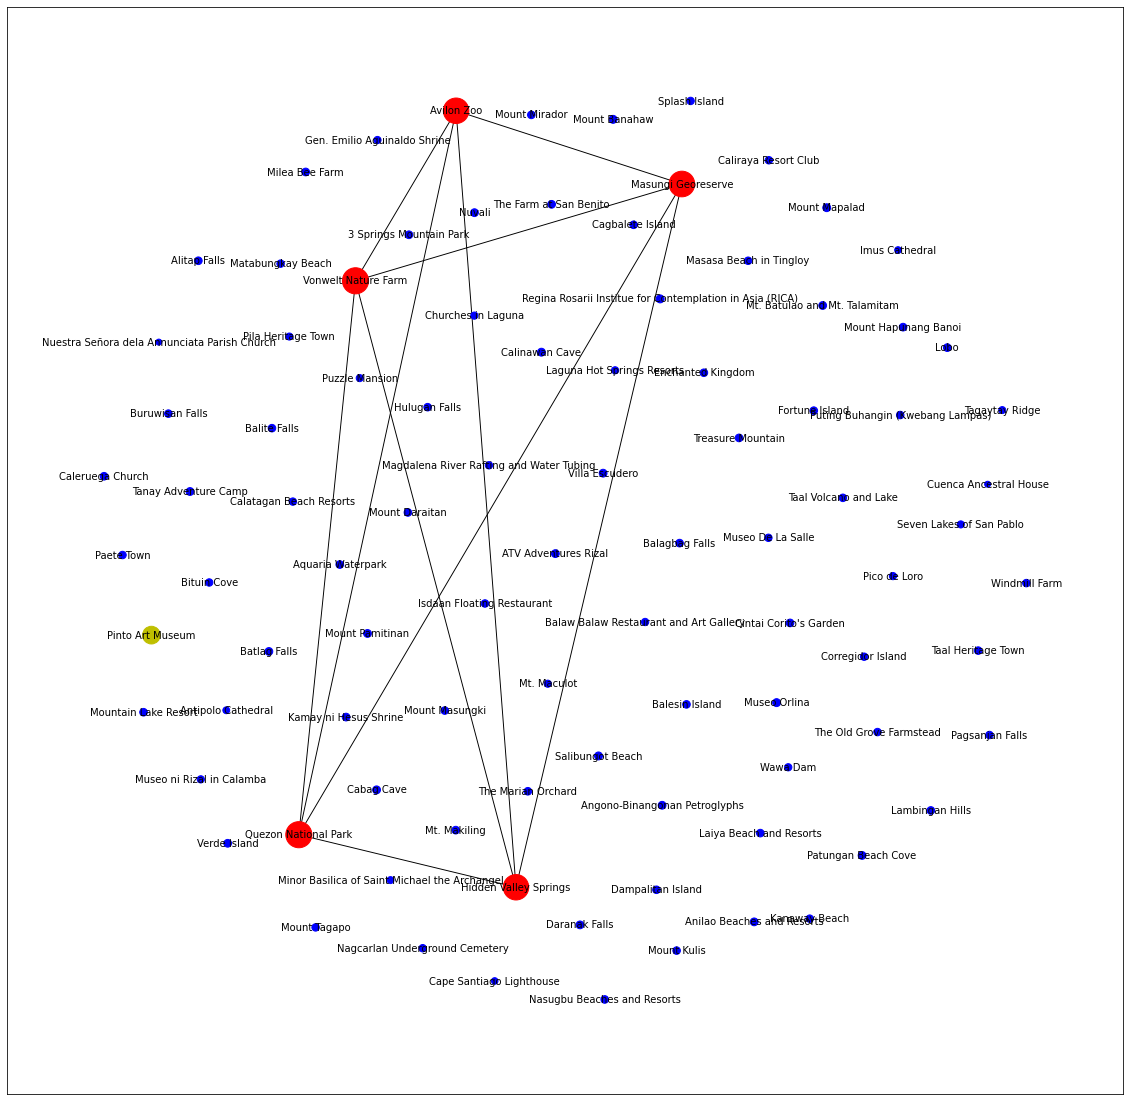

In [11]:
place_list = list(df['Location'])

top_n = list(top_5['Location'])

G = nx.Graph()

similarity = list(df['Similarity'])

for place in place_list:
    G.add_node(place)


for place1 in place_list:
    for place2 in place_list:
        if place1 == place2:
            continue
        else:
            G.add_edge(place1, place2)

colors = []
for i in range(len(similarity)):
    if place_list[i] in top_n:
        colors.append('r')
        similarity[i] *= 1000
    elif similarity[i] >= max(similarity) / 2:
        colors.append('y')
        similarity[i] *= 500
    else:
        colors.append('b')
        similarity[i] *= 100

edge_width = []
for i in range(len(place_list)):
    for j in range(i+1, len(place_list)):
        if place_list[i] in top_n and place_list[j] in top_n:
            edge_width.append(0.95)
        elif similarity[i] >= max(similarity)/2 and similarity[j] >= max(similarity)/2:
            edge_width.append(0.5)
        else:
            edge_width.append(0)

pos = nx.spring_layout(G)

plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, width=edge_width, node_size=similarity, node_color=colors, font_size=10, font_color='black')

# Create Tour Iternerary

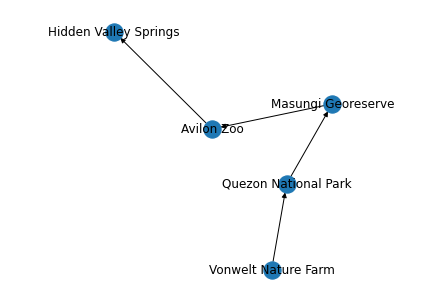

In [12]:
df_recom_places = top_5

edges=[]
for i in range((df_recom_places.shape[0])-1):
    edges.append(((df_recom_places["Location"][i], df_recom_places["Location"][i+1])))
edges

G = nx.DiGraph(edges)

nx.draw(G, with_labels=True)
plt.margins(x=0.4)